# Human Action Detection

## Data Preprocessing

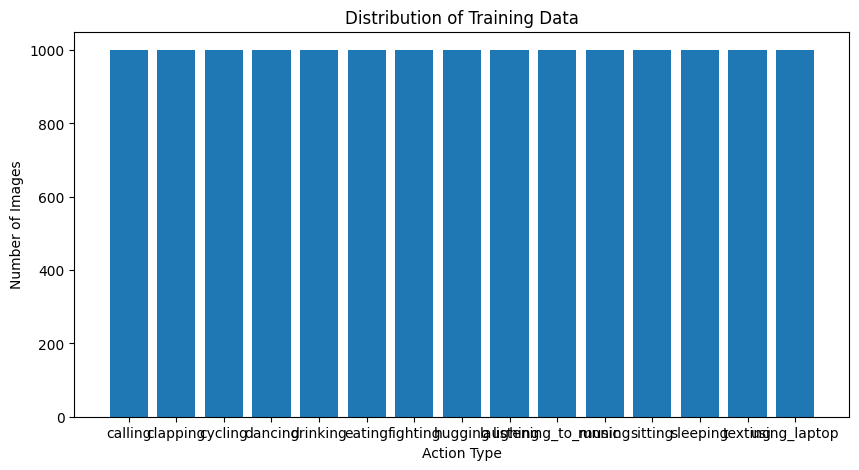

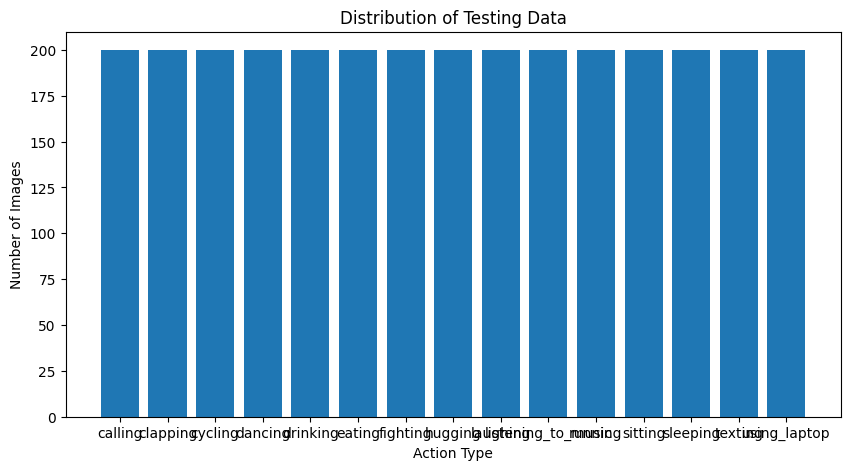

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter

path = 'emirhan_human_dataset/datasets/human_data'
train_data_path = path + '/train_data'
test_data = path + '/test_data'

def analyze_dataset(path, title):
    # get the list of all the files in the subfolders
    data_files = os.listdir(path)
    categories = []
    for file in data_files: 
        if os.path.isdir(path + '/' + file):
            categories.append(file)

    # then I want to get a count of the number of files in each of the subfolders
    action_type_counts = {}
    for action in categories:
        action_type_counts[action] = len(os.listdir(path + '/' + action))

    plt.figure(figsize=(10, 5))
    plt.bar(action_type_counts.keys(), action_type_counts.values())
    plt.xlabel('Action Type')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.show()

analyze_dataset(train_data_path, title="Distribution of Training Data") 
analyze_dataset(test_data, "Distribution of Testing Data")

## Model

In [9]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

# Data preparation using ImageDataGenerator
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    "emirhan_human_dataset/datasets/human_data/train_data",
    target_size=(128, 128),
    batch_size=128,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    "emirhan_human_dataset/datasets/human_data/test_data",
    target_size=(128, 128),
    batch_size=128,
    class_mode='categorical',
    shuffle = False)

base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(128, 128, 3), pooling='avg')
base_model.trainable = False  # Freeze the base model to not train it
inputs = base_model.input
x = Dense(64, activation='relu')(base_model.output)
x = Dense(64, activation='relu')(x)
outputs = Dense(len(train_generator.class_indices), activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1)]
model.fit(train_generator, validation_data=test_generator, epochs=5, callbacks=callbacks, verbose=1)
model.save('final_model.h5')

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Epoch 1/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 30s 231ms/step - accuracy: 0.3374 - loss: 2.0504 - val_accuracy: 0.5717 - val_loss: 1.3065
Epoch 2/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 26s 221ms/step - accuracy: 0.6466 - loss: 1.0942 - val_accuracy: 0.6213 - val_loss: 1.1923
Epoch 3/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 26s 218ms/step - accuracy: 0.7002 - loss: 0.9412 - val_accuracy: 0.6220 - val_loss: 1.1628
Epoch 4/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 26s 216ms/step - accuracy: 0.7313 - loss: 0.8428 - val_accuracy: 0.6357 - val_loss: 1.1356
Epoch 5/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 26s 219ms/step - accuracy: 0.7491 - loss: 0.7843 - val_accuracy: 0.6417 - val_loss: 1.1185


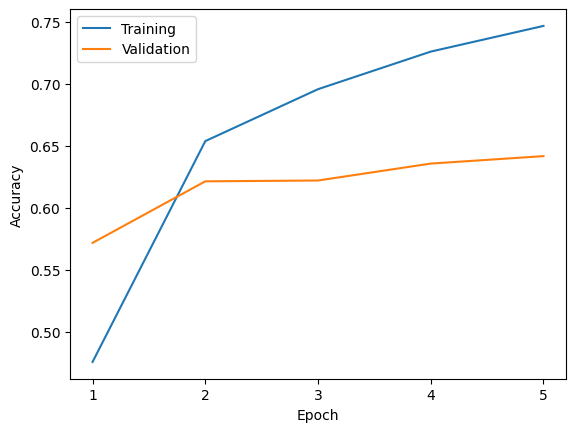

In [10]:
# Evaluate training and validation accuracy
history = model.history.history
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
epochs = len(history['accuracy'])
plt.xticks(range(epochs), [str(i+1) for i in range(epochs)])
plt.legend(['Training', 'Validation'])
plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step
Test Accuracy: 0.64


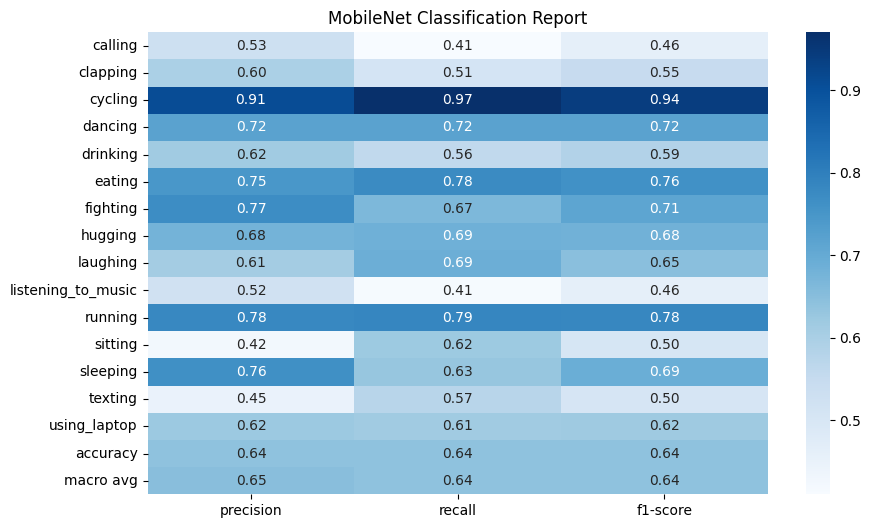

In [18]:
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

test_accuracy = np.mean(predicted_classes == true_classes)
print(f"Test Accuracy: {test_accuracy:.2f}")

class_labels = list(test_generator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.drop('support', axis=1, inplace=True)

plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :], annot=True, fmt=".2f", cmap="Blues") 
plt.title('MobileNet Classification Report')
plt.show()


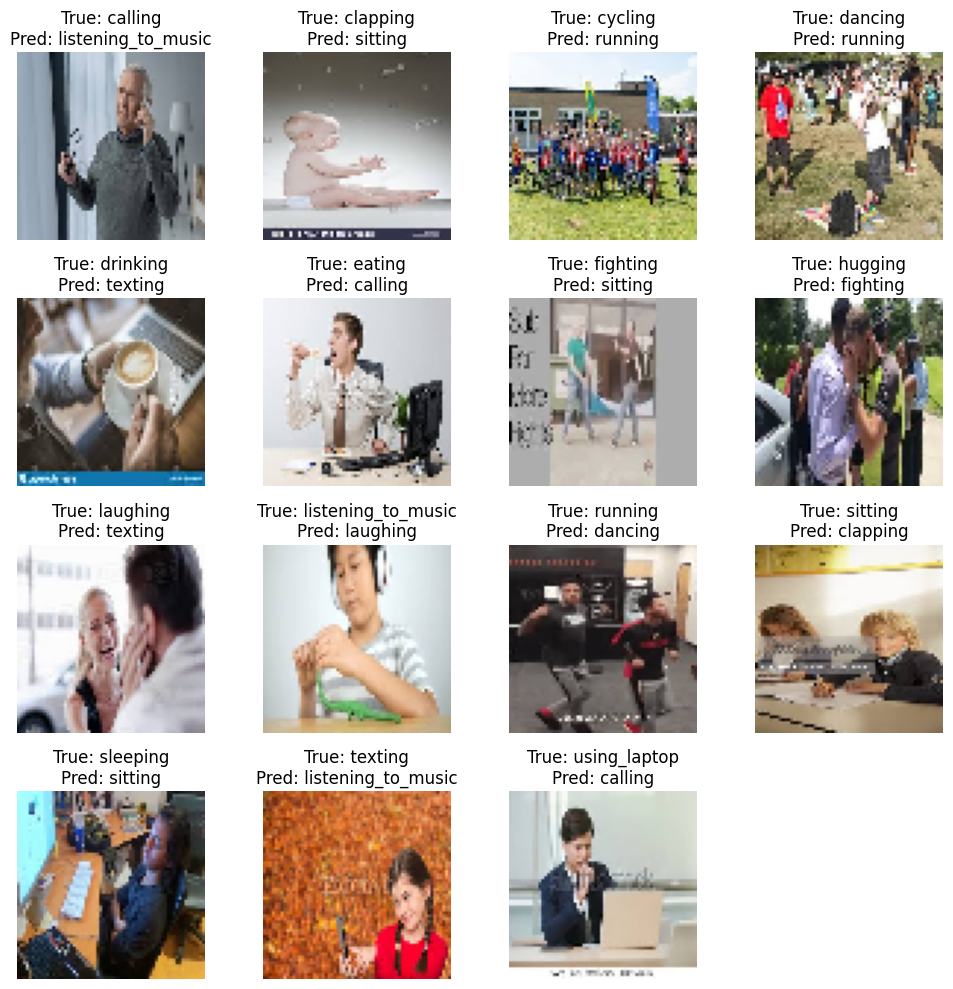

In [19]:
misclassified_samples = {}
for idx, (pred, true) in enumerate(zip(predicted_classes, true_classes)):
    if pred != true and true not in misclassified_samples:
        misclassified_samples[true] = idx
        if len(misclassified_samples) == len(test_generator.class_indices):
            break

index_to_class = {v: k for k, v in test_generator.class_indices.items()}

plt.figure(figsize=(10, 10))
cols = 4
rows = (len(misclassified_samples) + cols - 1) // cols 

for i, (true, index) in enumerate(misclassified_samples.items(), start=1):
    img_path = test_generator.filepaths[index]
    img = load_img(img_path, target_size=(64, 64))
    plt.subplot(rows, cols, i)
    plt.imshow(img)
    plt.title(f"True: {index_to_class[true]}\nPred: {index_to_class[predicted_classes[index]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()